Inputs : 
 - 2- or 3- channel 3D image (widefield + deonvolution)
 - 

Assumptions :
 - if you use the filter_by_size flag, spots are assumed to be of similar size

Parameters :
 - approximate XY radius of a cell
 - approximate Z height of a cell
 - approximate size of a spot

The pieces I need are:
 - DoG
 - Thresholding (Otsu and Triangle)
 - MIP
 - Labeling
 - region statistics
 


## Parameters 

In [3]:
#!python
chNuclear_n = 0
ch1_n = 1
ch2_n = 2

voxSize = 0.16 * 0.16 * 0.24; # um^3

nuclei_dog = True
nuclei_mip = False      # Coloc: True, Single: False
nuclei_sigma = [2,2,1]  # Coloc: [10 10 3], Single: [2 2 1]
nuclei_bkg_sigma = [69,69,12]
c1_tophat = 10
c2_tophat = 10
c1_sigma = [1.5,1.5,1]
c2_sigma = [1.5,1.5,1]
filterBySize = False
singleCell = True

In [4]:
#!python

#@ImageJ ij
#@OpService ops

## Open test dataset 

In [5]:
image = ij.io().open("example_data/test1.tif")
w = image.dimension(0)
h = image.dimension(1)
ch = image.dimension(2)
d = image.dimension(3)

[w,h,ch,d]

Some utility functions

In [6]:
from net.imglib2 import FinalInterval

getZSliceXYZ = lambda im,z : ij.op().run("crop", im,
                                     FinalInterval.createMinSize(
                                         0, 0, z,
                                         im.dimension(0), im.dimension(1), 1), True)

In [7]:
getMid = lambda im : getZSliceXYZ(im,im.dimension(2)//2)

Crop each channel separately into `ch1` `ch2` and `nuc`.

In [8]:
nuc, ch1, ch2 = [ ij.op().run(
    "crop", 
    image, 
    FinalInterval.createMinSize(0,0,i,0,w,h,1,d),
    True) 
                 for i in [chNuclear_n, ch1_n, ch2_n] ]

In [9]:
[ getMid(a) for a in [nuc,ch1,ch2] ]

<img src="data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAfEAAAC3CAYAAAACRGe4AACAAElEQVR42uydV89s21G1iR8555xzNLbJDiSbDCbnnHPONsEEg21MDsYG28gEIYKEkOCSG65BXAASfwHukZDeT09Lz9GgPEPNfnvvcwxnS0vdu9/u1avXmmuOWaNGjXqN13u917t73dd93cv2Oq/zOnev/dqvfXnM5zzW5/V99fX8/2u91msNn+dr12yv+Zqv2X5Pfg+v1c/WY+Hvo+PN//M7Z5/vbKtz1PlddZv9ffb+0ed3r83O3+5a5N9Xx1z33/3ek9/Z2ec1+zv53s51nJ2z2XWZ/Z4c//mY43d1X5zch/n+1Wfzvqzvq/PDyf0x+/7Z+Nxdn+7+R/NizqHMr3Wu9fXV89k5GX1HPvoZv281X+/m7/p9/+///b//8ZjHm49svMf35bmof8//+5zzlZ/3XPA8z2XdR91//d35W0bHU/frceR7fe45rtg5up6r7x+N7dH9/hqv8Rqvur3+67/+HVt+IQc8u7ijbQXWFfRmAO7z2YRwn20E4J2JbwS0uxt49r7d/jvH3z3mzqQ/+ttqHyeAs5s8dxPmbMG1unYnwDs7nmsXA6vjuXZRcd/3j8bWDgw7i+ITED1dzK7mktW9eHrfz8bA6jzUOW12D4/AsgJbBbMZEI6Ax++p56ruq4Lm6PzWc59b/t3/jwK8CoT1/yOArccoUCbo+jk/m99Zgd7P+VzQrUCev3UE9DwXD0cLizzeCuC5v9k5Hb3u+1f3RY7bKYi/wRu8wSNAPhqEq5Vg50bLwZwnow781c25WgGfTiCdyXj3u1YTZOe4d9HILbZO9FsXCbcArdmxrH7nLlK6VVS8YwLyZnkQUfh9N4+rG8nPQOcW42q1qOxG9J2ocLb43y2QO0A9Y3ZW9/OKOaigOQK4BKMK4KPXKiDXOXMGrrM5dhVwdJnWURSbv3sEpDUyryCe4MhzMCkj7vy8mMVjAj7bG77hG/6P10fRud+ZiwJfSxCvv2MUtftb3F9iXMW7eg5zgdHFK8H7kecetAe+o9BnN1OlcSqlsxsYOwDfDbgVDdeZqDsr7tWNvjtH16YRZu+dLQh2A+Fain5HRe+inNXx7uj1W4L5imW4RTT9MCLwzr460eU1KZ/Z/mYg3hm/da4ZRYj3jfRXgL1bSHfSgkbHI9AdUc0JDAmICQyjebNGsnUurYBao9iaCqznoEbds8fZ8SZ45cJkFomPInc/Y2CZQC5WAdJuCbQ8B8TZKstcKXqe5/8rjT9bfOXx1Ws9uy6zdEkuaHKcr+bYVwFxVzse0IwuGR1U5ijy4u/yK9cA+Goi6OxvRvF2wG1Fo41ukA69fhKN3jpS79Dju2i4Pq+0T4daP8nj76j5LtNykpu+NaU+uzmvTQuc5nNnoLR7f51gbqVbqeCTc8gqOjyh1keU5IlGZbdIH80DK5p5BuwVGCvdOsq11gApFxOV9Rxdx9HvW+Xa6xhIYJwxA5Warr+xPk9aO0HV/2e0/EZv9EYXEM/IO987Opd10VEpeIE/v2+kGRv9hkq7z2j1WX59NP6XNHrS6Zm4n628RjT4CMxm0fZsgTCLVrsr5BWFf+vc+iqC6IhGOvR6R4xzn8iqm07o5q93wrSdoHB3jUZAV+n/zuLkYUbBD+O7rk0ZnEbfCYIn0ets0TD6/Oje2dHt+f5dmqiej44eoLICs8fRbxjlcSuQjCK90cRe3z+js0cLoh2zURdEs7l5lJNPlrXS4wlWI+F0zSXXzwnEfjaZYv9mBM6W1HoCcN0S5/IYk873ezNKz8i8AnFdqMzO4ep8jp6PQHyaG5+B+OwEjy7kioLPAXMK4Dsg7b7/NEJZAe3oO1cgvlr43JIaPIn0d/nA0/O42u8o3z6Kkq65Xl2xWic6fqzT5/c5zmvYnpF6/drF7mycnLBnq4XxbmGxu89O0g4jBnKXS65zaeZgR5RzRonmWRNURlG6wOj7VynH0Vw+eq3DqM6qm2av1f3nd9Z8c42yBWipcgE+wd0tafIE4jyH+TnPr/vL/VRQzwh+tJAaqc5HvzX3MVrEzuavV4nE60qj5mNWgLtTma4G8i5y7VDZ14Bil54/Vap3I4rdJLUDuJMJtNKIHUX7Kt++m+xOcu47arlTUnZCs9+XHr+mtO/WJWm31AB0qip21PFswtktEEbjrDPWZyVX9R6sYHGyqNgJ83altJ1zV2njVFjnvJsglGBVaV7/n/sagcvoGGp0vBO2VWX8jOKfBYCrCqcqiEsgzlx4BVZz4wm8/j/xzYWB+6vvSaCui4FKvSflvxMiZiC7YmG6ot4hiM/oh1294q5MoaN23JWsndLbK1A5AdVRTe1swure4DOQvKV6eCcgW0Xi16iSr2UD6qQ9y6WvovrO89Nc9LXlXLsc/y1BvMssdMqrVuzTLie8Ko/pakpOx/zumGbK7FsI/Fb7nR3TKCqvSu0E5tGWKuyRQGxUjzwC10pl7zxBVn4fu9rrKpIeKbzr8eaipiq9R1S6gEpu3OicR//PI1t93XNqlJ8LgBTT1ei9Pl8JFEdlZKOUyUhTtps//oeorarTc4CNLnKn/KprClNvjI4hwX3p9WtNI3ZR+Yy+2kX9XcV9Vy17Uqd9qmA/NcLYidk6IqMTSr1Dr1+rE7iFwOwWavNrBHCni65VxccI1LrXrcvmzY6pI5Bd1TLvIv1ZVJ2lkTVS7Sz6Z+rkCuYVxKtyeuTnMQLrCoqjGulR6nRnGrMKuCow1bKp0X5rtJ6frcKvel4yQk4w9vkbv/EbXwD7Td7kTS7PR9R4Ktszp15p+FGUPluQVD1CPh+llEdVGadlZq+iTh/V/I2A6sQ0YFXwPov+V7R0p8b0hN4b5eeuAfNupLASuZ0o97sT4INwwXsQ2zWCqd0C4+S33JrqPqkImNWBX0ulz8SFOxOTHWCfVH3s7rmTUsxOxNutENlR5h2AXkXbq3rrWa1xrUuuQqrMEVf90iiXvDMWyUXN6vyNwH52Dur8vVO9d8rNVvXdnjMjbAD7Td/0TS+g/WZv9mZ3b/EWb3H35m/+5o8AeVLgqtoz+uY9vFdwH0XgKxOYmSPdis3o6K92EfkjdPrI8WakhOysiGdChtXqLQvvZ6UNq4h2pCTdOb91VbDXLCRmzk2dG/5aID5JK1wrnruPccjOLvVUt3BLW97TUrfVayeugI+GsG1Wt39NNH7KzJwKV1fK9p0epRsEnI6tWbQ9Y+hmgU2NwEe52BS4JeBkRD6aS2cCsno+ZkHTrOJo5sCZ5WYj29eZG93KbjbrwkeAKjUO+LIB4AD3W7/1W1/AGyDnOa8Bzn5e0M/IXeD29YzSq5iuXqddjfnI9nUmikwjn9Vc9So58cy1ZDQ+o2m6vrs7p5+88LVOcEf5XCu06VLTu+h5liPaOdztHKi65XO7nP21OcpOdHzf0r2ZP/CDiuJPTXBO6e2OecwpiJ+kC24F7LPx2tWSdFNAu+i6I/g8MXtaCdxG4tGu7eusdnoXoa48u6uKugrWRnRujdhXtc0zS1X3uQoqUv+wm4dnNPsqZ7z7Pake18xF2pxHwJrtbd/2bS8ADqj7yN+TOud1FwEAvODt+/i/72FjH0bwWT9eHeVG6ehVZdcIv3bzxxDEK5Uz8/btANssXzITVcyS/SuV3yyS7UQQuzxyl20YnYMV3VjzaTuB4CwfuJtETyLsroisyxbcegFxzWdni5mdc18XFLvA32UFbu00d9LoZnX+Zm5hHaq5S9fvdDan5jQdpfhOQ3LiHFnzn0khz0qORmVGo/zrTPDmHJ2Ro+A2yh/v1NIn9rZdDJhF8KsU66g2flbL7e9P8RpADIC/5Vu+5d3bvd3bPRJ9A75E5TxKlWf07gKATeod8BbYeTRS5z1Z7lYtZEd176vxPvMk2KXShmYvqfRbKes6CvTVBZvliEY5hG6pw4n45ZQK7+Tda9lLl5b

## Difference of Gaussians

In [10]:
vars={
    "input": ij.op().convert().float32(ch1),
    "sigmaBig": [3,3,1],
    "sigmaSmall": [1,1,0.5]
}

output = ij.op().eval("gauss(input, sigmaBig)-gauss(input,sigmaSmall)", vars)

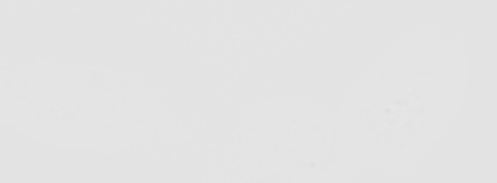

In [11]:
output

In [12]:
#ops.filter().dog(input, vars['sigmaBig'], vars['sigmaSmall'])

## Thresholding (Otsu and Triangle)

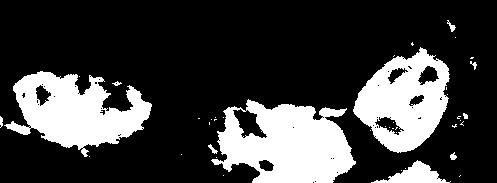

In [13]:
ij.op().threshold().otsu(getMid(nuc))

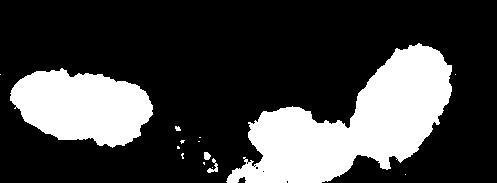

In [14]:
ij.op().threshold().triangle(getMid(ch1))

In [15]:
ij.op().threshold().triangle(ij.op().image().histogram(ch1))

5646​.95166015625

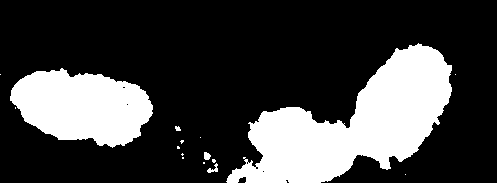

In [16]:
getMid(ij.op().threshold().triangle(ch1))

## Maximum Intensity Projection

In [17]:
ij.op().help('project')

Available operations:
	(IterableInterval out) =
	net.imagej.ops.transform.project.DefaultProjectParallel(
		IterableInterval out,
		RandomAccessibleInterval in,
		UnaryComputerOp method,
		int dim)
	(IterableInterval out) =
	net.imagej.ops.transform.project.ProjectRAIToII(
		IterableInterval out,
		RandomAccessibleInterval in,
		UnaryComputerOp method,
		int dim)
	(IterableInterval out) =
	net.imagej.ops.transform.project.ProjectRAIToIterableInterval(
		IterableInterval out,
		RandomAccessibleInterval in,
		UnaryComputerOp method,
		int dim)

From https://imagej.net/ImageJ2_Python_Scripts

In [18]:
im = nuc

from net.imagej.ops import Ops
 
projected = ij.op().create().img([ im.dimension(d) for d in [0,1] ])
 
# Create the op and run it
proj_op = ij.op().op("stats.max", im)
ij.op().transform().project(projected, im, proj_op, 2)

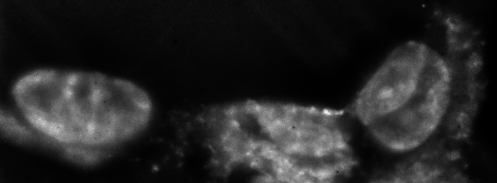

In [19]:
projected

In [20]:
from net.imagej.ops import Ops

def getMIP(im): 
    projected = ij.op().create().img([ im.dimension(d) for d in [0,1] ])

    # Create the op and run it
    proj_op = ij.op().op(getattr(Ops.Stats, "Max"), im)
    ij.op().transform().project(projected, im, proj_op, 2)

    return projected

In [21]:
[ getMIP(im) for im in (ch1,ch2,nuc) ]

<img src="data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAfEAAAC3CAYAAAACRGe4AABzQ0lEQVR42u29R4983VX9b3LOOeeMI7Z5nACDwYATth/bGAdMFgZElBAiiCQkJgxAMIEpHjJnwHvhVcCw/9olfZ7/h/Xb595zq6u7q7vPVzrq+lZXuF1171l7r7322i/79E//9BvWp33ap631DNbLXvay0+L2zOOP3H/O8azv5bJrXc/Xe+1t3c+1+RxX7k9P+W+c2Z+nz4ktEF8bwfVe9Jd8zQWiC9DXethgehRgPzcAX0B+xt/+nDPxxwxeRyK7rag/P4fbvO5aa611u+vxuWfhTx3Mz2VLp0B8RcGPfwM4hzpPAF/Z+VprPcy+85xBfG+/ea4gvjLxZ1yH7aK4LSBfGfjTp9T3rvGZ3y9q/m7A/HAddFHMC8QXnf40go+97HrmdWbqU+uzfzp18ad4rT+Wc/S51oEvKfZ6SgK+i/ztBvEF5o97s9o7Qbao81G2ftvNcQUAT0NwtvaFy4P4c8++n3MmPhI1LmHbqt9Pg+fWRjJTa1/ljbXW+rRbsWALvJ9nTfzif+vKwq+X+jsH2EaR/Sytd7SHfAHyYg/Wul0pbAH482o5m+0IOhvEF5hfFqQuDWhH2jG2aPQ9AF9Z9Vpr3Y/B0gLt55eV7wV3Z2Xin/EZn3FaC8Qvnxlfmj4/53dbJ8qsin2B9fPIstf1f3nV+V4wvdbzq5FfVJ0OgH/mZ37m/wHyx3Yx3yeoXLpmfERMNpuNH1G1b2UJl1LfrrWo9OdWCtsTNS3AXiB+a7EjoA2I11rU+nkX55Gs+twgYNbU5QhIX6q17BL19LXWemodI2udB3Az+PNU2sxuDeIG8qTVlx3rNkid2/d3m1r06AueqY/PnBgz1OCi1dd67gH8slW9HxA3DnV49BREbqP7pv6+BO1VG98H8RkV5R6VduQxRzPoGYr7yElyVyWERUsvuvupqs0XiF8mUzV4byWWjxW4L5KNA9xLoX7MlGEUmR9tK5gF8L2NYeb5e+0Ns1Hibdzh1nocQra1BxwTh+6VzNY6vyZ+pIPqKWXkV99i9lAbxLmiiSPU+jnUyezzZkD4HIe22WM+Yv+61lrP0YBpgfDls/EjGPXsPqu7BvG7BuuZ7PBIxDzjaHaEDr9EbeScAQnnZANbWfs5LWhrrfWUs/GLWmeutQvgnV5rhFnPGsQvBbz3kWnPXECzNeu7bhm49PsdFZ8dff+twOGS/etrXSfNvqj029Pra12WTrfwulvPFsgfCsQvnfXPOuM8mzrJHQchl+hpvwvP+LXWegiF+vJDv9tM3F4mtT7rsz7rtPj/swbyh6qHz77fuT2Y60J62Vmf02zd/Cka+Ky11O+3NX1aAHw3mXgH4tzeAvFn8Z1csyr9KWTTD5WBn+sGtCfsW6C6QPy5tpkemUmw1t2AeIJ53n6Wordrbym7Zvr5GgH/HDHbUQr9XO/olY0/fQB/KkB/xBlxrYepiWcmPmsbvjLxKwTvtS7rFjTrCrcAeK3nNNBoZd4P45vegXhHqx9xHH3ywrZra+FY6+7o+Fnjmdne9AXkaz31lrK1rh/EZ63DVyZ+xyrPtR4O7I8MN5n1AF5CuLUeu7HLKuXd/9SyWYX6DJg/SeHbNQD4Wtebsd/GvOYuxpPepld9rbVWee/xgzjgfS6IPzkgv6s+8XURLLX8XanaF32/1kMwNyvzvv+54YlPBdKf/dmfffM5n/M5QxC3wO0Ixb7U6QvAF9BPer+vtdZjLausa/1+QLzLnsnCC8A/93M/9wTmBnLfPgfEH+33u0U1nAvsK1JdYH7bVrVVF19r0eoLvDsqvQC8lrPxAnRAvaPUn3SNfItOvw2Ir7XWXWfiqza+1qVU5ysxeVgA3wJuC9oA7A7AMzN/NnXySwnb1sm51n3Wxdda666nH6697eEy8M7QxZR5rgTxSwH5o/j+Z0H82bjfrPWgQpblhLb+xmugyNde97C17wTwkYBtD8xngPzRi95uk4kvI4S1HjIjX0HBWqvG/fhbx/bAO7Nrg3MH4qNsfeTsNsrQH825chsqfZ2ka52rWl8AstYC8gXgW7Vv18BnaPSuNj7KzDvB26Mda3qbLHyttRatvtZj7/1eTmwPT53vZeBbwF0iN//s1l5GnrT9owLyBeJrLbHbWisLX6B9XwC+lQV3ivNRds0q8O7WHoiP6ut7o02vFsRX/Xut+6TXF4Cs9ZAe6Gsve/i2sa2suwPpDry3QLx7zgjItzL1qwdyf9gr+17roTLxBexrrQlkT2vq2Mwc8BFwJzhj7uL/cx+3u8fsZeYcxxbl3rHVVwfiiz5f6xpq4ef4WC/l+lprz7qO6/koeO/R4aNl0K71eZ/3eUNQ78A93d1GKvgtSv2qzq91Iaz1GMF8ZnTqArIF4mvdb/a9V+vuqPItwHVG3QF3/az1+Z//+S/dZo0AHiDvfNcT3EcCt6s6x9aFsNZD0+lHgf6uFO8L+Bd9vtbtAHzPiCXBOYHXANytBGgAnOX/j14vs/Guna3rJ7/abHyB91rX1Ec+a495SQBf4P20WsrWdXX/9Ln7u7fEaQbTAtov+IIvuPnCL/zC06rbHQB3WXYCuJ/b/X9Eq28ZyTxqEF8n61rX1je+tVEvIFtrDSl5GABPgxZn3FuZNOD9RV/0RTdf/MVffPpZy2CeWXauehyL57HyMc7IOyAfzSTfs2RdIL7WWrdoQ7sLAF9BwdNpI1vX0t1n3910sQTsBF4Au8D7S77kS07ry77sy26+9Eu/9HRfrQTlDrDJ4Hm9WiNQd2CQtHrOId8aYXqVeLkAfK2n3kO+VOxLzLbWZQB8azSo69wGbcAWwAW0v/Irv/Kl9VVf9VWnn1/+5V9++r2f4+fmT0CfgCAfMwLyrWx8bw751Z136wJY6zHWys9tPVtAvgB8rfMBfIs2B7wTuA24Bd61CqwLuL/6q7/65mu+5mtOq24D5GTjzrIJAAzauQzq+dzMxvco9a3RpVebia8Td61rVa5fmmJfhjNPA6zXvnW316Cp8wK6TnTW0d3OkrlddDkA/hVf8RUnwP7ar/3a0/q6r/u6088C8gJ3U+sG7LrftwkKoOP9GFPzLB+/gTwFbnvZ+FUB+QLxta45A1gAu9bKuB9evFbgVgBdQFvgC8h2YE3G7AWwFtg6A//6r//60/rGb/zGm2/4hm843a77C+QTsDMIqJ+1DOI8httbojkYhHRycyb+SARu68Rd6/pr5LcxdRm9xlK3LwBfa5yBmz4v0Ctw/O7v/u6b7/zO7zyBMEDqLLgD7g6AC8gr+/6mb/qml1YBOSAOrQ7t7tsEANDvtcjs6yer3o+MfATiWy5uj4hSXyfuWtedid8V2C4AX4C91nb9u4CtwK5AsDLlV73qVTff//3ffwLcAmHXsZPeBtwBU9fCycIBbwAcWt1gXfchfKv76v88lscD6jzOxwSQQ6cfAfHZnvEF4mutdcGe8qVaf1ptYgvQ7z8DR7hWYFfgV5ntt3/7t9/8wA/8wM13fdd33XzzN3/zCYCdOTsLJnM25V0/AViDcQUHLOj1+p3vq//X+xRg13313t/6rd96WnW77uMxDizMEpwrcBtl5FcUdK4TeK3HPQHtCPiOft/V3heQX8fI0HXO3z+FDoAX4FUWW+BZVPr3fM/3nMD8W77lW14CT2fCzobrpwEdyrsWGTagXUFBrW/7tm87rbpdAF3vU7fJ1Otn3VfH8epXv/rm5S9/+Yner/vyWNyy5tazzvxlVBcfgfmVZePrJF7r8bSbLXBdFPpal7++ACVT6AV21LQLcAtUC8ABWmjwzKAzI3bdmvvrMabRDdoFyrXqPQgWAPB63Hd8x3ecwPuFF164ef3rX/8SOwCQQ/MTQFQQQva95eA2Gkc6AvMF4mutdceU+hqKsgaXrHU8Cy9AK8CrrLXo6ALDAkWoa8AV0CVbLgAF1AFSgJwsHEA

## Region Statistics

See https://github.com/imagej/imagej-scripting/blob/master/src/main/resources/script_templates/Tutorials/Ops_Threshold_Measure.py

In [22]:
inputData = getMid(ch1)
thresholded = ij.op().threshold().triangle(inputData)

In [23]:
#@ OpService ops

from net.imglib2.algorithm.labeling.ConnectedComponents import StructuringElement
from net.imglib2.roi import Regions;
from net.imglib2.roi.labeling import LabelRegions;

# call connected components to label each connected region
labeling=ops.labeling().cca(thresholded, StructuringElement.FOUR_CONNECTED)

# get the index image (each object will have a unique gray level)
labelingIndex=labeling.getIndexImg()

# get the collection of regions and loop through them
regions=LabelRegions(labeling)
for region in regions:
	# get the size of the region
	size=region.size()

	# get the intensity by "sampling" the intensity of the input image at the region pixels
	intensity=ops.stats().mean(Regions.sample(region, inputData)).getRealDouble()

	print "size",size,"intensity",intensity

size 15306 intensity 18028.0772899
size 7978 intensity 22411.0864366
size 1 intensity 6015.92236328
size 1 intensity 5700.85009766
size 3 intensity 5771.83284505
size 23 intensity 6628.71246603
size 2 intensity 5658.01855469
size 12 intensity 6275.63024902
size 2 intensity 5583.02636719
size 8 intensity 5891.24804688
size 45 intensity 7177.6469184
size 12 intensity 6094.59358724
size 5 intensity 5836.35175781
size 14 intensity 6650.89760045
size 1 intensity 5578.73046875
size 5 intensity 5829.36005859
size 51 intensity 6377.25906671
size 1 intensity 5555.16943359
size 1 intensity 5730.44726562


## TopHat filtering

In [24]:
ch1.firstElement().getClass()

class net​.imglib2​.type​.numeric​.real​.FloatType

In [25]:
ops.stats().min(ch1)

0​.1966971755027771

From http://nbviewer.jupyter.org/github/imagej/tutorials/blob/master/notebooks/1_-_Using_ImageJ/ImageJ_Ops/12_-_Mathematical_Morphology.ipynb

In [26]:
ops.help("divide")

Available operations:
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$DivideByte(
		ArrayImg arg,
		byte value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$DivideDouble(
		ArrayImg arg,
		double value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$DivideFloat(
		ArrayImg arg,
		float value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$DivideInt(
		ArrayImg arg,
		int value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$DivideLong(
		ArrayImg arg,
		long value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$DivideShort(
		ArrayImg arg,
		short value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$DivideUnsignedByte(
		ArrayImg arg,
		byte value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$DivideUnsignedInt(
		ArrayImg arg,
		int value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$DivideUnsignedLong(
		ArrayImg arg,
		long value)
	(ArrayImg arg) =
	net.

In [27]:
#@OpService ops

from net.imglib2.type.numeric.real import FloatType

mx = ops.stats().max(ch1).getRealDouble()/255
ch1_r = ops.run("math.divide",ch1,FloatType(mx))

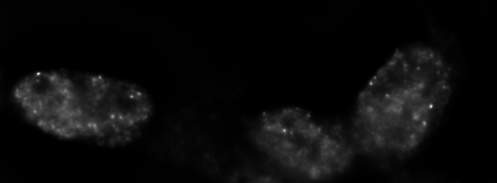

In [28]:
getMid(ch1_r)

In [29]:
from java.lang import System

def tic():
    global time_WQEOIWUE
    time_WQEOIWUE = System.currentTimeMillis()

def toc():
    global time_WQEOIWUE
    return System.currentTimeMillis()-time_WQEOIWUE

def toc_():
    print(toc())

In [30]:
from net.imglib2.algorithm.neighborhood import DiamondShape
shape = DiamondShape(3)

pre = ch1_r

tic()
#im = ops.morphology().topHat(pre, [shape])
toc_()

0


In [31]:
from net.imglib2.algorithm.neighborhood import DiamondShape
shape = DiamondShape(3)

pre = ops.convert().uint8(ch1_r)

tic()
#im = ops.morphology().topHat(pre, [shape])
toc_()

0


In [32]:
from net.imglib2.algorithm.neighborhood import DiamondShape
shape = DiamondShape(3)

pre = ij.op().run("copy.rai", ops.convert().uint8(ch1_r))

tic()
#im = ops.morphology().topHat(pre, [shape])
toc_()

0


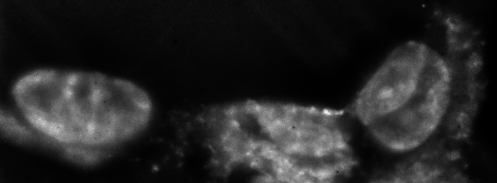

In [33]:
getMIP(im)

In [34]:
ops.stats().max(ch1_r)

255​.0

In [35]:
ops.stats().max(im)

20630​.86328125

In [36]:
im.firstElement().getClass()

class net​.imglib2​.type​.numeric​.real​.FloatType

In [37]:
ops.help("slice")

Available operations:
	(RandomAccessibleInterval out) =
	net.imagej.ops.slice.SliceRAI2RAI(
		RandomAccessibleInterval out,
		RandomAccessibleInterval in,
		UnaryComputerOp op,
		int[] axisIndices,
		boolean dropSingleDimensions?)
	(ImgPlus out) =
	net.imagej.ops.transform.crop.CropImgPlus(
		ImgPlus in1,
		Interval in2,
		boolean dropSingleDimensions?)
	(RandomAccessibleInterval out) =
	net.imagej.ops.transform.crop.CropRAI(
		RandomAccessibleInterval in1,
		Interval in2,
		boolean dropSingleDimensions?)

In [38]:
ops.help("transform.crop")

Available operations:
	(ImgPlus out) =
	net.imagej.ops.transform.crop.CropImgPlus(
		ImgPlus in1,
		Interval in2,
		boolean dropSingleDimensions?)
	(RandomAccessibleInterval out) =
	net.imagej.ops.transform.crop.CropRAI(
		RandomAccessibleInterval in1,
		Interval in2,
		boolean dropSingleDimensions?)

In [39]:
ch1_out = ops.create().img(ch1)
#tophatop = ops.op("morphology.topHat",[ch1,[shape]])
ops.slice(ch1_out,ch1,tophatop,[0,1],True)

[ERROR] null
Traceback (most recent call last):
  File "dummy.py", line 3, in <module>
NameError: name 'tophatop' is not defined

	at org.python.core.Py.NameError(Py.java:290)
	at org.python.core.PyFrame.getname(PyFrame.java:257)
	at org.python.pycode._pyx36.f$0(dummy.py:3)
	at org.python.pycode._pyx36.call_function(dummy.py)
	at org.python.core.PyTableCode.call(PyTableCode.java:171)
	at org.python.core.PyCode.call(PyCode.java:18)
	at org.python.core.Py.runCode(Py.java:1614)
	at org.python.core.__builtin__.eval(__builtin__.java:497)
	at org.python.core.__builtin__.eval(__builtin__.java:501)
	at org.python.util.PythonInterpreter.eval(PythonInterpreter.java:259)
	at org.python.jsr223.PyScriptEngine.eval(PyScriptEngine.java:57)
	at org.python.jsr223.PyScriptEngine.eval(PyScriptEngine.java:31)
	at javax.script.AbstractScriptEngine.eval(AbstractScriptEngine.java:264)
	at org.scijava.script.ScriptModule.run(ScriptModule.java:160)
	at org.scijava.module.ModuleRunner.run(ModuleRunner.java:168)

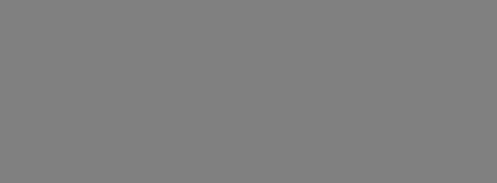

In [40]:
getMid(ch1_out)

In [41]:
ch1_out = ops.create().img(ch1)
gop = ops.op("filter.gauss",[ch1,10])
ops.slice(ch1_out,ch1,gop,[0,1],True)

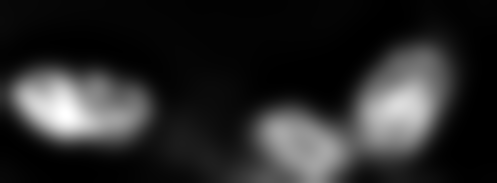

In [42]:
getMid(ch1_out)

In [43]:
ch1_out = ops.create().img(ch1)
gop = ops.op("filter.gauss",[ch1,10])
ops.slice(ch1_out,ch1,gop,[2],True)

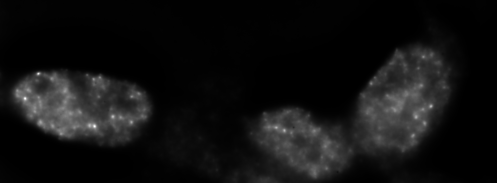

In [44]:
getMid(ch1_out)

## Laplacian

A smoothed laplacian is basically a gaussian followed by a second derivative.

In [45]:
from net.imglib2.type.numeric.real import DoubleType

def laplace(im,sigma):
    gim = ops.filter().gauss(im,sigma)
    s = ops.create().img(gim, DoubleType())
    for n in range(im.numDimensions()):
        gimi = ops.filter().partialDerivative(ops.filter().partialDerivative(gim,n),n)
        ops.math().add(s,s,gimi)
    return s


In [46]:
from net.imglib2.img.array import ArrayImgs

a = ArrayImgs.floats(range(1000),[10,10,10])

a

In [47]:
ops.filter().partialDerivative(a,1)

In [48]:
ops.run("partialDerivative",a,1)

In [49]:
laplace(a,1)

In [50]:
#laplace(ch1,3)

In [51]:
out = ops.create().img(getMid(ch1), DoubleType())
ops.filter().derivativeGauss(out, getMid(ch1), [2,2], 3)

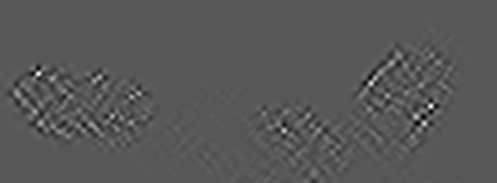

In [52]:
out

In [53]:
#!python
#@OpService ops

ops.help("convolve")

Available operations:
	(RandomAccessibleInterval out) =
	net.imagej.ops.filter.convolve.ConvolveNaiveF(
		RandomAccessibleInterval in1,
		RandomAccessibleInterval in2,
		OutOfBoundsFactory obf?,
		Type outType?)
	(RandomAccessibleInterval out) =
	net.imagej.ops.filter.convolve.ConvolveFFTF(
		RandomAccessibleInterval in1,
		RandomAccessibleInterval in2,
		long[] borderSize?,
		OutOfBoundsFactory obfInput?,
		OutOfBoundsFactory obfKernel?,
		Type outType?,
		ComplexType fftType?)
	(RandomAccessibleInterval out) =
	net.imagej.ops.filter.convolve.ConvolveNaiveC(
		RandomAccessibleInterval out,
		RandomAccessible in,
		RandomAccessibleInterval kernel)
	(RandomAccessibleInterval out) =
	net.imagej.ops.filter.convolve.ConvolveFFTC(
		RandomAccessibleInterval out,
		RandomAccessibleInterval in1,
		RandomAccessibleInterval in2,
		RandomAccessibleInterval fftInput,
		RandomAccessibleInterval fftKernel,
		boolean performInputFFT?,
		boolean performKernelFFT?)

## Let's put it all together...

```
CH1 : tophat(c1_sigma) -> laplace(c1_sigma) -> invert -> triangle -> bopening(1)
CH2 : tophat(c2_sigma) -> laplace(c2_sigma) -> invert -> triangle -> bopening(1)
NUC : DoG(nuclei_sigma,nuclei_bkg_sigma) -> otsu 

for nuc in label(nuclei0):
    'Size','P2A','Minimum','CartesianBox','Mean'
```

Modified slightly for perfo issues...

```
CH1 : "x - gauss(x,c1_sigma)" -> laplace(c1_sigma) -> invert -> triangle -> bopening(1)
CH2 : "x - gauss(x,c2_sigma)" -> laplace(c2_sigma) -> invert -> triangle -> bopening(1)
NUC : DoG(nuclei_sigma,nuclei_bkg_sigma) -> otsu

for nuc in label(NUC)
    get statistics for nuc: 'Size','Mean'
    nucg = threshold(gauss(nuc,5))
    
    count spots from CH1 in nucg
    count spots from CH2 in nucg
```

In [54]:
from net.imglib2.outofbounds import OutOfBoundsMirrorFactory
from net.imglib2.img.array import ArrayImgs

def laplace(im,sigma):
    oobf = OutOfBoundsMirrorFactory( OutOfBoundsMirrorFactory.Boundary.SINGLE )
    g = ops.filter().gauss(im,sigma)
    out = ops.create().img(g)
    for dim in range(im.numDimensions()):
        dims = [1]*im.numDimensions()
        dims[dim] = 5

        kdd = ArrayImgs.doubles([-1,0,2,0,-1], dims)
        out = ops.math().add(out,ops.filter().convolve(g,kdd,oobf))
    return out

In [55]:
# Does "x - gauss(x,c1_sigma)" -> laplace(c1_sigma) -> invert -> triangle -> bopening(1)
def processSpotImage(im,sigma):
    im = ops.eval("in - gauss(in,s)", {'in':im,'s':sigma})
    im = laplace(im, sigma)
    #out = ops.create().img(im)
    #im = ops.image().invert(out,im)
    im = ops.threshold().triangle(im)
    im = ops.morphology().open(im,[DiamondShape(1)])
    return im

In [56]:
ch1_processed = processSpotImage(getMid(ch1),c1_sigma)

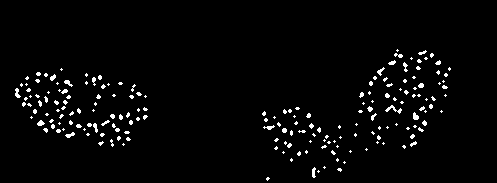

In [57]:
ch1_processed

In [58]:
ch1_processed = processSpotImage(ch1,c1_sigma)

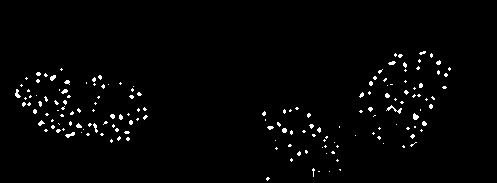

In [59]:
getMid(ch1_processed)

NUC : DoG(nuclei_sigma,nuclei_bkg_sigma)


In [60]:
def processNuc(im,nuclei_sigma,nuclei_bkg_sigma):
    out = ops.filter().dog(im,nuclei_bkg_sigma,nuclei_sigma)
    out = ops.threshold().otsu(out)
    return out

In [61]:
nucMask = processNuc(getMid(nuc),nuclei_sigma[:2],nuclei_bkg_sigma[:2])

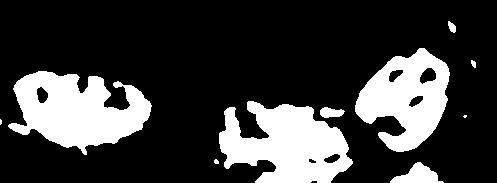

In [62]:
nucMask

In [63]:
nucMask = processNuc(im,nuclei_sigma,nuclei_bkg_sigma)

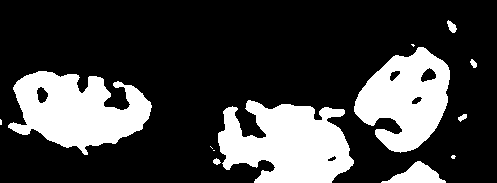

In [64]:
getMid(nucMask)

### Labeling

In [65]:
from net.imglib2.algorithm.labeling.ConnectedComponents import StructuringElement
import net.imglib2.roi.labeling.LabelRegions

cca = ops.labeling().cca(getMid(nucMask), StructuringElement.FOUR_CONNECTED)
ccar = LabelRegions(cca)

In [66]:
for r in ccar:
    print(r.size())
    print(ops.stats().sum(Regions.sample(r,getMid(ch1_processed))).getRealDouble())
    break

76
0.0


In [67]:
ui.show(ch1_processed)

[ERROR] null
Traceback (most recent call last):
  File "dummy.py", line 1, in <module>
NameError: name 'ui' is not defined

	at org.python.core.Py.NameError(Py.java:290)
	at org.python.core.PyFrame.getname(PyFrame.java:257)
	at org.python.pycode._pyx64.f$0(dummy.py:1)
	at org.python.pycode._pyx64.call_function(dummy.py)
	at org.python.core.PyTableCode.call(PyTableCode.java:171)
	at org.python.core.PyCode.call(PyCode.java:18)
	at org.python.core.Py.runCode(Py.java:1614)
	at org.python.core.__builtin__.eval(__builtin__.java:497)
	at org.python.core.__builtin__.eval(__builtin__.java:501)
	at org.python.util.PythonInterpreter.eval(PythonInterpreter.java:259)
	at org.python.jsr223.PyScriptEngine.eval(PyScriptEngine.java:57)
	at org.python.jsr223.PyScriptEngine.eval(PyScriptEngine.java:31)
	at javax.script.AbstractScriptEngine.eval(AbstractScriptEngine.java:264)
	at org.scijava.script.ScriptModule.run(ScriptModule.java:160)
	at org.scijava.module.ModuleRunner.run(ModuleRunner.java:168)
	at o

In [68]:
from net.imglib2.view import Views
from net.imagej.ops.logic import IIToIIOutputII
ui.show(ops.run(IIToIIOutputII.And,nucMask,ch1_processed))

[ERROR] null
Traceback (most recent call last):
  File "dummy.py", line 3, in <module>
NameError: name 'ui' is not defined

	at org.python.core.Py.NameError(Py.java:290)
	at org.python.core.PyFrame.getname(PyFrame.java:257)
	at org.python.pycode._pyx65.f$0(dummy.py:3)
	at org.python.pycode._pyx65.call_function(dummy.py)
	at org.python.core.PyTableCode.call(PyTableCode.java:171)
	at org.python.core.PyCode.call(PyCode.java:18)
	at org.python.core.Py.runCode(Py.java:1614)
	at org.python.core.__builtin__.eval(__builtin__.java:497)
	at org.python.core.__builtin__.eval(__builtin__.java:501)
	at org.python.util.PythonInterpreter.eval(PythonInterpreter.java:259)
	at org.python.jsr223.PyScriptEngine.eval(PyScriptEngine.java:57)
	at org.python.jsr223.PyScriptEngine.eval(PyScriptEngine.java:31)
	at javax.script.AbstractScriptEngine.eval(AbstractScriptEngine.java:264)
	at org.scijava.script.ScriptModule.run(ScriptModule.java:160)
	at org.scijava.module.ModuleRunner.run(ModuleRunner.java:168)
	at o

In [74]:
lr

[ERROR] null
Traceback (most recent call last):
  File "dummy.py", line 1, in <module>
NameError: name 'lr' is not defined

	at org.python.core.Py.NameError(Py.java:290)
	at org.python.core.PyFrame.getname(PyFrame.java:257)
	at org.python.pycode._pyx71.f$0(dummy.py:1)
	at org.python.pycode._pyx71.call_function(dummy.py)
	at org.python.core.PyTableCode.call(PyTableCode.java:171)
	at org.python.core.PyCode.call(PyCode.java:18)
	at org.python.core.Py.runCode(Py.java:1614)
	at org.python.core.__builtin__.eval(__builtin__.java:497)
	at org.python.core.__builtin__.eval(__builtin__.java:501)
	at org.python.util.PythonInterpreter.eval(PythonInterpreter.java:259)
	at org.python.jsr223.PyScriptEngine.eval(PyScriptEngine.java:57)
	at org.python.jsr223.PyScriptEngine.eval(PyScriptEngine.java:31)
	at javax.script.AbstractScriptEngine.eval(AbstractScriptEngine.java:264)
	at org.scijava.script.ScriptModule.run(ScriptModule.java:160)
	at org.scijava.module.ModuleRunner.run(ModuleRunner.java:168)
	at o

In [77]:
from net.imglib2.algorithm.labeling.ConnectedComponents import StructuringElement
from net.imglib2.roi import Regions
from net.imagej.table import DefaultGenericTable
from net.imagej.table import IntColumn, DoubleColumn

pxx=0.3; pzz=0.5;

def getLabelRegion(mask):
    cc = ops.labeling().cca(mask, StructuringElement.FOUR_CONNECTED)
    return LabelRegions(cc)

def nCC(mask):
    return getLabelRegion(mask).getExistingLabels().size()

def countSpots(nucMask, spotChannels):
    lr = getLabelRegions(nucMask)

    table = DefaultGenericTable()

    IDs = IntColumn("ID")
    IDs.addAll([ i+1 for i,ch in enumerate(lr) ])
    table.add(IDs)

    labelSize = DoubleColumn("Nucleus size")
    labelSize.addAll([r.size()*pxx*pxx for r in lr])
    table.add(labelSize)

    for ich, ch in enumerate(spotChannels):
        slr = getLabelRegions(ch)

        spotsVolume = DoubleColumn("Spots volume channel {}".format(ich))
        spotsVolume.addAll([ ops.stats().sum(Regions.sample(r,ch)).getRealDouble()/255*pxx*pxx*pzz for r in lr ])
        table.add(spotsVolume)

        # TODO MISSING SPOT COUNT
        nSpots = IntColumn("Number of spots channel {}".format(ich))
        
        nSpots.addAll([ nCC(Views.randomAccess(Regions.sample(r,ch))) for r in lr ])
        table.add(nSpots)

    return table
    

In [78]:
table = countSpots(nucMask,[ch1_processed])

[ERROR] null
Traceback (most recent call last):
  File "dummy.py", line 1, in <module>
  File "dummy.py", line 34, in countSpots
AttributeError: type object 'net.imglib2.view.Views' has no attribute 'randomAccess'

	at org.python.core.Py.AttributeError(Py.java:207)
	at org.python.core.PyType.noAttributeError(PyType.java:1994)
	at org.python.core.PyObject.__getattr__(PyObject.java:1027)
	at org.python.pycode._pyx74.countSpots$2(dummy.py:37)
	at org.python.pycode._pyx74.call_function(dummy.py)
	at org.python.core.PyTableCode.call(PyTableCode.java:171)
	at org.python.core.PyBaseCode.call(PyBaseCode.java:154)
	at org.python.core.PyFunction.__call__(PyFunction.java:423)
	at org.python.pycode._pyx75.f$0(dummy.py:1)
	at org.python.pycode._pyx75.call_function(dummy.py)
	at org.python.core.PyTableCode.call(PyTableCode.java:171)
	at org.python.core.PyCode.call(PyCode.java:18)
	at org.python.core.Py.runCode(Py.java:1614)
	at org.python.core.__builtin__.eval(__builtin__.java:497)
	at org.python.co

In [71]:
table

[ERROR] null
Traceback (most recent call last):
  File "dummy.py", line 1, in <module>
NameError: name 'table' is not defined

	at org.python.core.Py.NameError(Py.java:290)
	at org.python.core.PyFrame.getname(PyFrame.java:257)
	at org.python.pycode._pyx68.f$0(dummy.py:1)
	at org.python.pycode._pyx68.call_function(dummy.py)
	at org.python.core.PyTableCode.call(PyTableCode.java:171)
	at org.python.core.PyCode.call(PyCode.java:18)
	at org.python.core.Py.runCode(Py.java:1614)
	at org.python.core.__builtin__.eval(__builtin__.java:497)
	at org.python.core.__builtin__.eval(__builtin__.java:501)
	at org.python.util.PythonInterpreter.eval(PythonInterpreter.java:259)
	at org.python.jsr223.PyScriptEngine.eval(PyScriptEngine.java:57)
	at org.python.jsr223.PyScriptEngine.eval(PyScriptEngine.java:31)
	at javax.script.AbstractScriptEngine.eval(AbstractScriptEngine.java:264)
	at org.scijava.script.ScriptModule.run(ScriptModule.java:160)
	at org.scijava.module.ModuleRunner.run(ModuleRunner.java:168)
	a

In [190]:
spots_processed = [ processSpotImage(ch,sigma) for ch,sigma in zip([ch1,ch2],[c1_sigma,c2_sigma]) ]

In [191]:
table = countSpots(nucMask,spots_processed)

In [192]:
table

,ID,Nucleus size,Spots volume channel 0,Spots volume channel 1
,1,16162​.02,1​.315941176470588,2​.3634705882352938
,2,27310​.5,2​.651117647058823,5​.29235294117647
,3,23613​.66,1​.062529411764706,3​.2894117647058816
,4,1402​.74,0​.001764705882352941,0​.029823529411764704
,5,19​.889999999999997,0​.0,0​.0
,6,429​.21,0​.0,0​.0
,7,157​.04999999999998,0​.0,0​.0
,8,239​.13,0​.0,0​.0
,9,0​.18,0​.0,0​.0
,10,0​.8999999999999999,0​.0,0​.0
